In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

#Models
from ConvNet import ConvNet
from MLP import MLP
from UNET import UNET
from losses import *
from siren import Siren

#Needed for training and evaluation
from RandomMatrixDataSet import RandomMatrixDataSet,SingularvalueMatrix, EigenMatrix
from train import train_on_batch, run_training
from evaluation import model_evaluation

#Seed and looks
torch.random.seed = 1234
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


#### Illustration of random matrix generation module

In [2]:
N = 2 
E = EigenMatrix(N,mu = 1,sigma = 10)
S = SingularvalueMatrix(N,cond = 10)
M = RandomMatrixDataSet(N)
M.from_eigenvalues(mu = 2, sigma = 0.2, diagonal = True)
M.compute_determinant()
M.det
M.compute_cond()


In [3]:
d = 3 #Matrix dimension
cond = 10

# Define model(s) hyperparameters
hidden_layers = 5 
hidden_features = 32
kernel_size = 3
filters = 32

#Initate some example models
reluMLP = MLP(d,hidden_layers, hidden_features)
CNN = ConvNet(hidden_layers,filters,kernel_size)
UNet = UNET(1,1)
SIREN = Siren(d,hidden_features, hidden_layers)


In [4]:
# Initialize network, for example here simple MLP
model = reluMLP

# Training parameters
loss_fcn = inv_MSE
batch_size = 100
lr = 1e-2
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)
k = 100000


In [5]:
#Characterize matrices for training. For example, diagonal matrices with randomized eigenvalues
matrix_parameters = {"N":batch_size,
                   "d": 3,
                  #"cond": 10,
                  "mu": 1,
                  "sigma":5,
                  "diagonal": True,
                  "similar": None}
#Run training
trained_model,loss_log,weighted_average_log,eval_loss_log,x_eval = run_training(k,model,loss_fcn,optimizer, matrix_parameters)

It=0	 loss=3.830e-01	  weighted_average=3.830e-01	 eval_loss=3.734e-01	
It=1000	 loss=1.734e-01	  weighted_average=1.653e-01	 eval_loss=1.753e-01	
It=2000	 loss=1.458e-01	  weighted_average=1.406e-01	 eval_loss=1.487e-01	
It=3000	 loss=1.296e-01	  weighted_average=1.240e-01	 eval_loss=1.255e-01	
It=4000	 loss=1.010e-01	  weighted_average=9.238e-02	 eval_loss=9.618e-02	
It=5000	 loss=6.631e-02	  weighted_average=6.080e-02	 eval_loss=6.525e-02	
It=6000	 loss=4.618e-02	  weighted_average=4.708e-02	 eval_loss=5.187e-02	
It=7000	 loss=2.659e-02	  weighted_average=3.760e-02	 eval_loss=4.206e-02	
It=8000	 loss=2.433e-02	  weighted_average=3.233e-02	 eval_loss=3.441e-02	
It=9000	 loss=2.040e-02	  weighted_average=2.742e-02	 eval_loss=3.057e-02	
It=10000	 loss=1.802e-02	  weighted_average=2.500e-02	 eval_loss=2.652e-02	
It=11000	 loss=2.140e-02	  weighted_average=2.468e-02	 eval_loss=2.592e-02	
It=12000	 loss=2.286e-02	  weighted_average=2.299e-02	 eval_loss=2.553e-02	
It=13000	 loss=1.283e-02	

### Some preliminary results from training

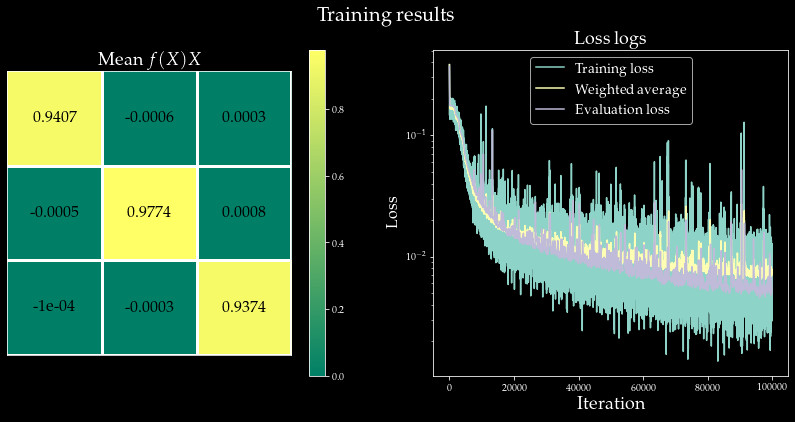

In [8]:
## Inspect if the model overfitted/how it trained on the data.
pred = trained_model(x_eval)

fig = plt.figure()
#Visualize how well the network output serves as an inverse
ax = fig.add_subplot(121)
mean_identity_approx = torch.matmul(pred,x_eval).mean(0)[0].detach().numpy()
img = ax.imshow(mean_identity_approx, cmap = 'summer')
for i in range(d):
        for j in range(d):
            t= ax.text(j, i, round(mean_identity_approx[i, j],4),
                       ha="center", va="center", color="black", fontsize = 16)
# Create colorbar
cbar = ax.figure.colorbar(img, ax=ax)
ax.set_xticks(np.arange(0,3,1)+0.5)
ax.set_yticks(np.arange(0,3,1)+0.5)
ax.set_title('Mean $f(X)X$', fontsize = 18)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.grid(color="w", linestyle='-', linewidth=3)
ax.tick_params( bottom=False, left=False)

# Plot loss logs
ax = fig.add_subplot(122)
ax.plot(loss_log, label = "Training loss")
ax.plot(weighted_average_log, label = "Weighted average")
ax.plot(np.linspace(0,k,len(eval_loss_log)), [x.detach().numpy() for x in eval_loss_log], label= "Evaluation loss")
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('Loss logs', fontsize = 18)
ax.legend(fontsize = 14)
fig.suptitle('Training results', fontsize=20)
ax.set_xlabel('Iteration', fontsize=18)
ylabel = ax.set_ylabel('Loss', fontsize=16)
#plt.savefig("training_results_diag.png")

### Illustration of evaluation module 

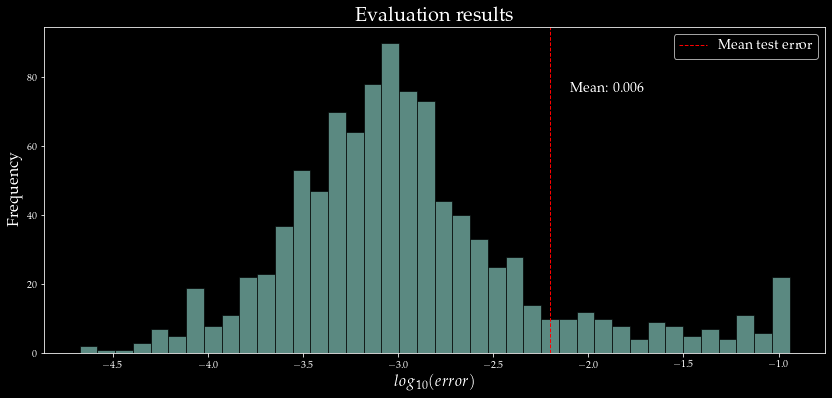

In [9]:
test_parameters = {"N":1000,
                   "d": 3,
                  #"cond": 10,
                  "mu": 1,
                  "sigma":0.3,
                  "diagonal": True,
                  "similar": True}
m = model_evaluation(trained_model,test_parameters)
fig = plt.figure()

#Visualize how well the network output serves as an inverse
ax = fig.add_subplot(111)
ax.hist(np.log10(m["errors"]), bins = 40, edgecolor='black', alpha=0.65)
ax.axvline(np.log10(m["mean_error"]), color='r', linestyle='dashed', linewidth=1, label = "Mean test error")
ax.set_xlabel("$log_{10}(error)$", fontsize = 16)
ax.set_ylabel("Frequency", fontsize = 16)
ax.legend(fontsize = 14)
min_ylim, max_ylim = plt.ylim()
plt.text(np.log10(m["mean_error"])*0.95, max_ylim*0.8, 'Mean: {:.3f}'.format(m["mean_error"]), fontsize = 14)
ax.set_title("Evaluation results", fontsize = 20);